---

## Exercise 4 : SARIMA-GARCH model, B 

We use the Gamestop (GME) stock, which is a stock favored by retail investors and gained a lot of traction thanks to a massive number of reddit users artificially making the price go up, with the clear intent to perform a short squeeze in order to "punish" big hedge funds which were "unfairly" short selling the stock. 
This lack of fundamental analysis and clear non-stationarity in the returns, and heteroskedasticity, makes it interesting to try to apply a SARIMA-GARCH model to this stock.

### Imports

In [50]:
import polars as pl
import numpy as np
import yfinance as yf
from datetime import date

import matplotlib.pyplot as plt

# from statsmodels.tsa.stattools import adfuller
# from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from useful_functions import check_stationarity, perform_lb_test
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
import itertools
from joblib import Parallel, delayed

In [51]:
# function to evaluate an ARIMA based on AIC
def evaluate_arima_model(time_series, arima_order):
    try:
        model = ARIMA(time_series, order=arima_order)
        model_fit = model.fit()
        return arima_order, model_fit.aic
    except Exception as e:
        print(e)
        return arima_order, None

### Pre-processing of the data

In [52]:
data = (
    pl.DataFrame(
        yf.download('GME', start='2015-01-01', end='2023-12-26').reset_index()
    )
    .select(
        pl.col("^.*Date.*$").cast(pl.Date).alias("date"), 
        pl.col("^.*Close.*$").alias("close")
    )
    .with_columns(
        pl.col("close").pct_change().alias('returns')
    )
    .drop_nulls()
)

[*********************100%***********************]  1 of 1 completed


In [53]:
data.head()

date,close,returns
date,f64,f64
2015-01-05,6.460138,0.027219
2015-01-06,6.26849,-0.029666
2015-01-07,6.195927,-0.011576
2015-01-08,6.26849,0.011711
2015-01-09,6.004281,-0.042149


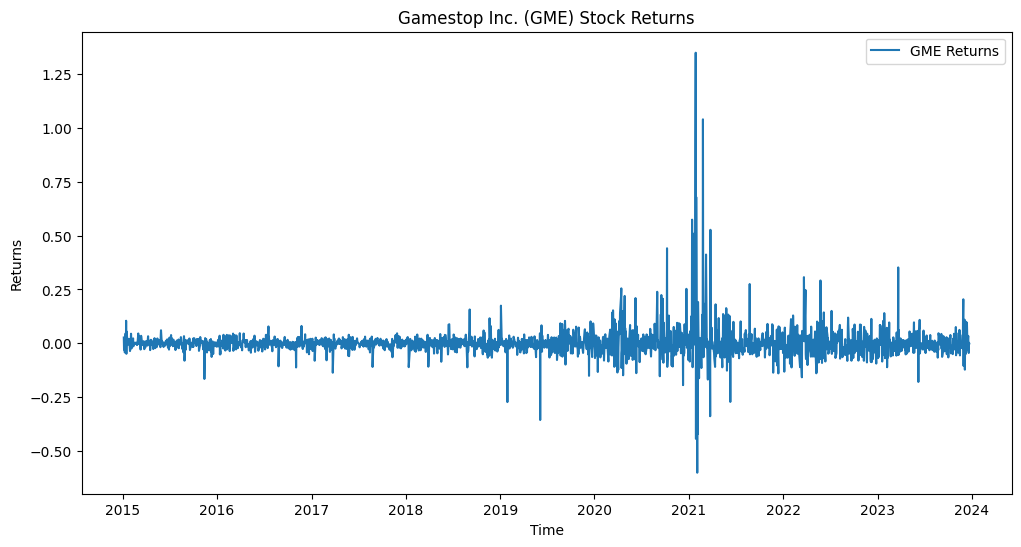

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(data.to_pandas().set_index('date')['returns'], label='GME Returns')
plt.title('Gamestop Inc. (GME) Stock Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()


### Checking for seasonality, stationarity and serial correlation

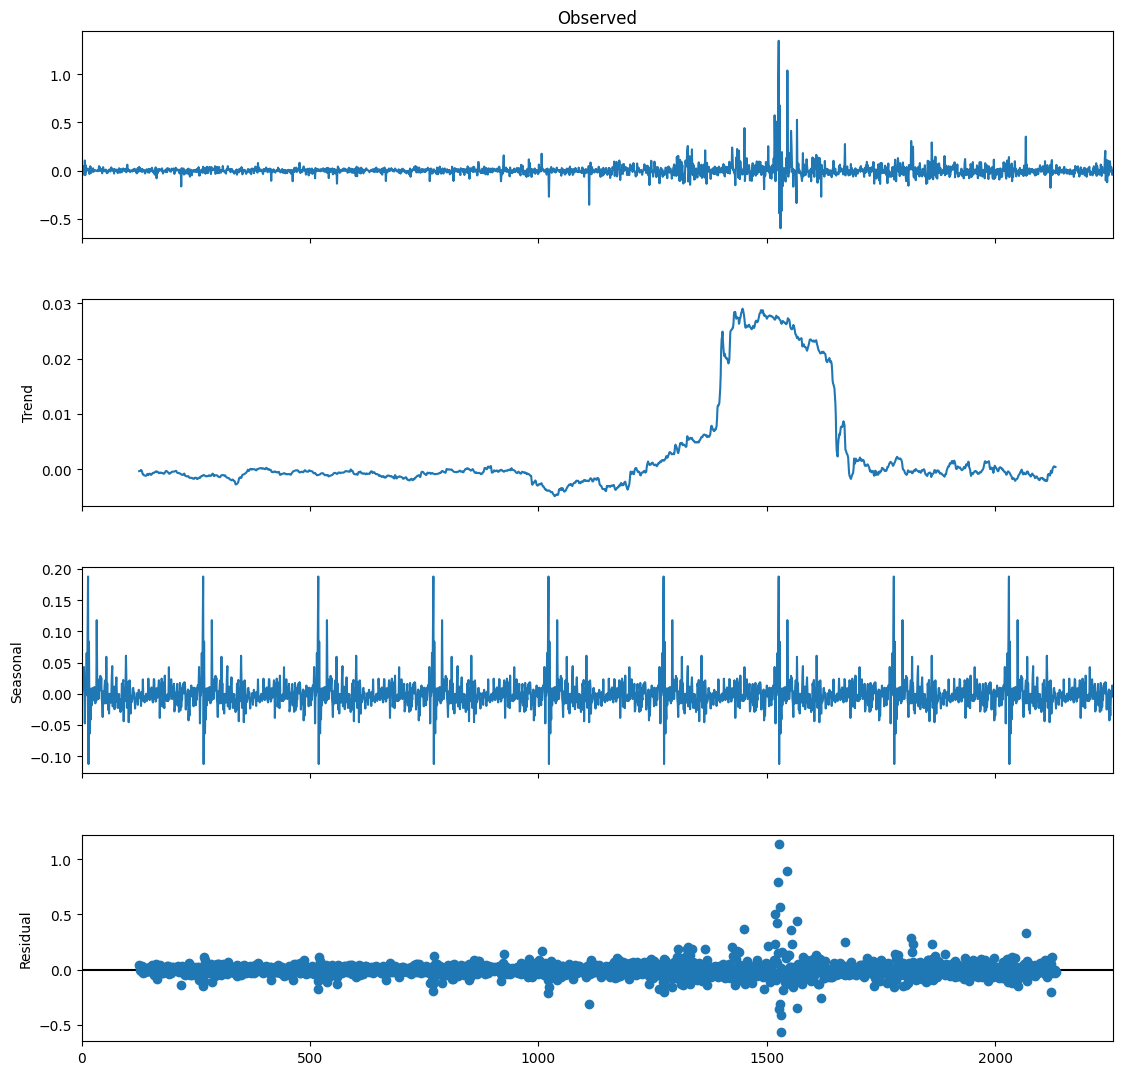

In [55]:
decomposition = seasonal_decompose(data.select('returns'), model='additive', period=252) 
fig = decomposition.plot()
fig.set_size_inches(12, 12)
plt.show()

We observe some seasonality, approximately every 252 days

In [56]:
check_stationarity(data.select('returns'))

ADF Statistic: -6.295090597150603
p-value: 3.5218199227404655e-08
Critical Values: 
 ['1% : -3.433284486749949', '5% : -2.8628363719623935', '10% : -2.5674601206080894']
We reject the null hypothesis at 5%.
 Data most probably has no unit root and is stationary


In [57]:
perform_lb_test(data.select("returns"))

LB Statistic: 364.324257445337
p-value: 4.251236690246453e-59
We reject the null hypothesis 
 There is most probably significant serial correlation in the returns.


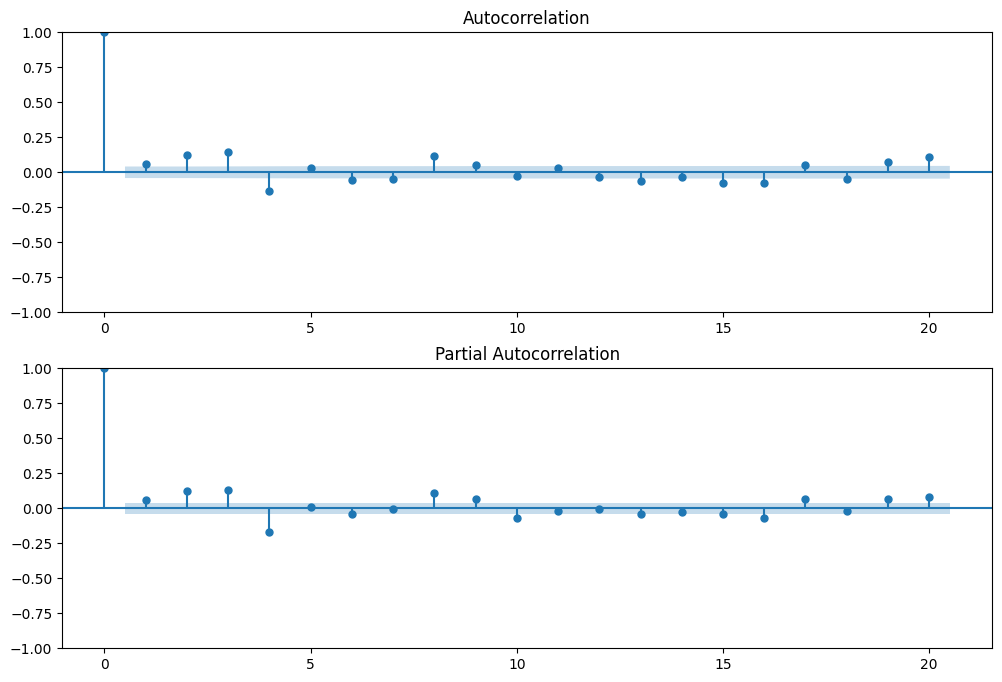

In [58]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.select("returns"), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.select("returns"), lags=20, ax=ax2, method='ywm')

We find significant autocorrelation at lags 2/3/4, with a light alternating geometrical decay

### Fitting the SARIMA model 

We define the in-sample and out of sample time series :

In [59]:
in_sample = data.filter(pl.col('date').le(date(2019,12,31)))
out_of_sample = data.filter(pl.col('date').gt(date(2019,12,31))) #strictly greater than last day of december => starts in Jan2020

We can then estimate the model on the in-sample

In [60]:
in_sample.head()

date,close,returns
date,f64,f64
2015-01-05,6.460138,0.027219
2015-01-06,6.26849,-0.029666
2015-01-07,6.195927,-0.011576
2015-01-08,6.26849,0.011711
2015-01-09,6.004281,-0.042149


In [61]:
# here we use parallel processing to find the best model quicker 
p = d = q = range(0, 5)  
pdq = list(itertools.product(p, d, q))
results = Parallel(n_jobs=-1)(delayed(evaluate_arima_model)(in_sample.select("returns").to_pandas()['returns'], order) for order in pdq)

best_score, best_order = float("inf"), None
for order, aic in results:
    if aic and aic < best_score:
        best_score, best_order = aic, order
        print(f'ARIMA{order} - AIC:{aic}')

print(f'Best ARIMA{best_order} - AIC:{best_score}')

ARIMA(0, 0, 0) - AIC:-5256.251975240588
ARIMA(0, 0, 3) - AIC:-5262.222794007268
ARIMA(3, 0, 0) - AIC:-5262.92919327145
Best ARIMA(3, 0, 0) - AIC:-5262.92919327145


In [62]:
sarima_model = sm.tsa.SARIMAX(in_sample.select('returns').to_pandas(), order=(1, 0, 3))
sarima_results = sarima_model.fit(disp=False)

In [63]:
print(sarima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                 1257
Model:               SARIMAX(1, 0, 3)   Log Likelihood                2636.254
Date:                Sun, 29 Dec 2024   AIC                          -5262.507
Time:                        21:12:03   BIC                          -5236.825
Sample:                             0   HQIC                         -5252.855
                               - 1257                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3467      0.259      1.341      0.180      -0.160       0.854
ma.L1         -0.3594      0.258     -1.395      0.163      -0.864       0.146
ma.L2          0.0496      0.029      1.690      0.0

In [64]:
train_pred = sarima_results.predict(start=0, end=len(in_sample.select('returns').to_pandas())-1, typ='levels')

In [65]:
sarima_forecast = sarima_results.get_forecast(steps=len(out_of_sample.select('returns').to_pandas()))
sarima_mean_forecast = sarima_forecast.predicted_mean
sarima_conf_int = sarima_forecast.conf_int()


In [66]:
train = in_sample.select('returns').to_pandas()['returns']
test = out_of_sample.select('returns').to_pandas()['returns']
# train_size = len(train)

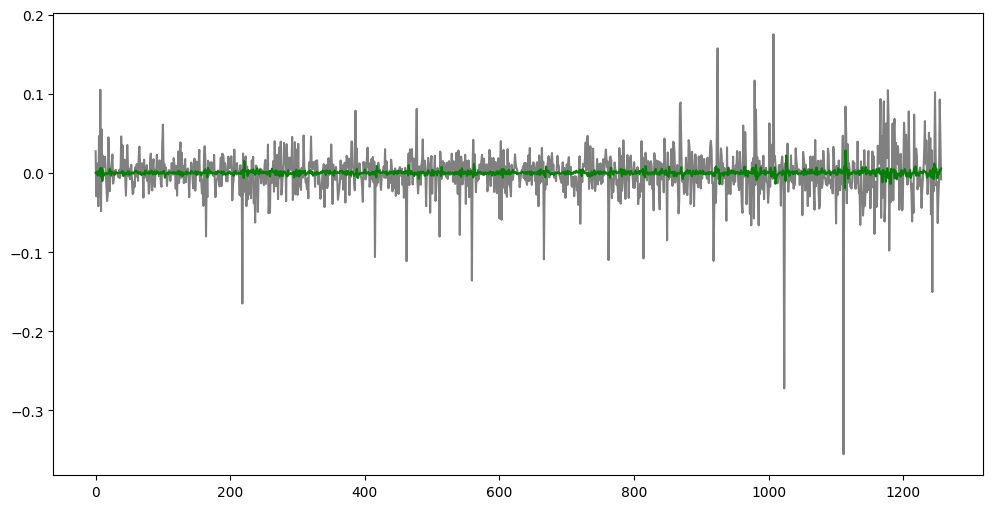

In [67]:
plt.figure(figsize=(12,6))
plt.plot(train, label='Training Data', color='gray')
plt.plot(train_pred, label='In-Sample Forecast', color='green')

In [68]:
train_size = int(len(in_sample))

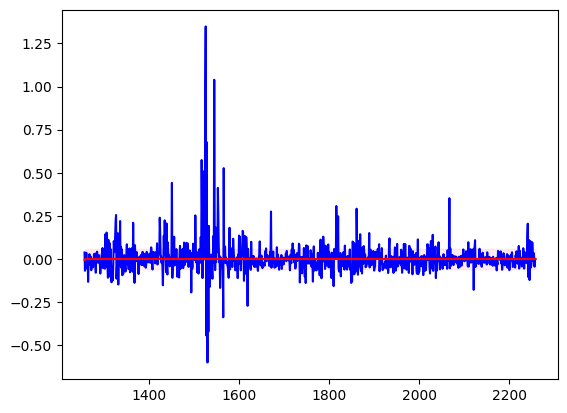

In [69]:
plt.plot(range(train_size, train_size + len(test)), test, label='Actual Test Data', color='blue')
plt.plot(range(train_size, train_size + len(test)), sarima_mean_forecast, label='Out-of-Sample Forecast', color='red')
plt.fill_between(range(train_size, train_size + len(test)), sarima_conf_int['lower returns'], sarima_conf_int['upper returns'], color='pink', alpha=0.3, label='95% Confidence Interval')

We can see that there is a problem with the cutoff date: a big unexpected event happened in 2021, which here isn't captured during learning

However, this changed the dynamic of the stock and therefore this should be included in the training so that we are able to capture the rest of the events

### Fitting the GARCH model

We get the residuals from the SARIMA model, perform tests and then fit the model

In [70]:
residuals = sarima_results.resid

In [71]:
check_stationarity(residuals)

ADF Statistic: -35.45474064959176
p-value: 0.0
Critical Values: 
 ['1% : -3.4355671297788666', '5% : -2.8638438984080117', '10% : -2.5679966213893057']
We reject the null hypothesis at 5%.
 Data most probably has no unit root and is stationary


In [72]:
perform_lb_test(residuals, lags=20)

LB Statistic: 18.199714241670478
p-value: 0.5742539211550576
We do not reject the null hypothesis 
 There is most probably no significant serial correlation in the returns.


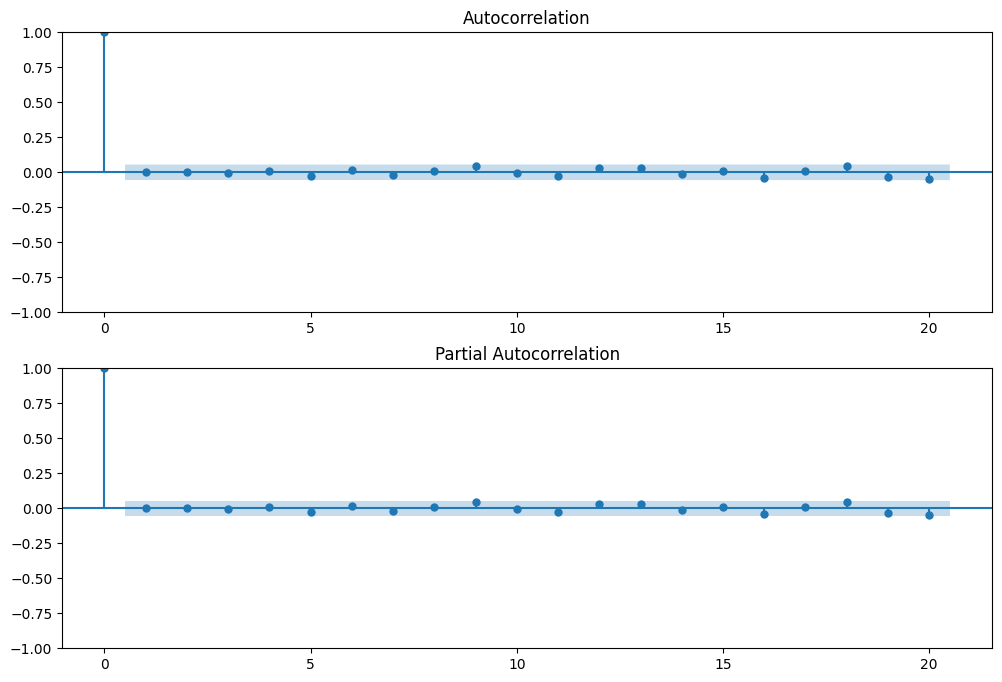

In [73]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax2, method='ywm')

We find small autocorrelation at lags 11, 16 and 20, when we include 2021 in the training. However here there is no remaining serial correlation...

In [74]:
arch_test_result = het_arch(residuals)
print(arch_test_result)

(np.float64(1.3183394417850915), np.float64(0.9993985691090674), 0.13080930719620348, 0.9994121070494676)


In [75]:
# Interpret the results
lm_test_stat, lm_p_value, f_test_stat, f_p_value = arch_test_result
if lm_p_value < 0.05:
    print("Reject the null hypothesis (Lagrange Multiplier test): There is significant ARCH effect in the returns.")
else:
    print("Fail to reject the null hypothesis (Lagrange Multiplier test): There is no significant ARCH effect in the returns.")

if f_p_value < 0.05:
    print("Reject the null hypothesis (F-test): There is significant ARCH effect in the returns.")
else:
    print("Fail to reject the null hypothesis (F-test): There is no significant ARCH effect in the returns.")


Fail to reject the null hypothesis (Lagrange Multiplier test): There is no significant ARCH effect in the returns.
Fail to reject the null hypothesis (F-test): There is no significant ARCH effect in the returns.


In [76]:

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(10*residuals, vol='Garch', p=11, q=11)
garch_results = garch_model.fit(disp='off')

# Print the summary of the model
print(garch_results.summary())

c:\Users\faune\miniconda3\envs\timeseriescourse\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08823. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -151.523
Distribution:                  Normal   AIC:                           351.046
Method:            Maximum Likelihood   BIC:                           474.321
                                        No. Observations:                 1257
Date:                Sun, Dec 29 2024   Df Residuals:                     1256
Time:                        21:12:04   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -8.1234e-03  9.126e-03     -0.890      0.

### Rolling window 

We then generate the forecasts using a rolling window with both models

!! careful: this takes a long time to compute

In [77]:
# Define the sarima_garch_forecast function
def sarima_garch_forecast(train_data, steps=1):
    # Fit the SARIMA model to the returns
    sarima_model = sm.tsa.SARIMAX(train_data, order=(1, 0, 3), seasonal_order=(0, 0, 0, 0))
    sarima_results = sarima_model.fit(disp=False)
    sarima_forecast = sarima_results.get_forecast(steps=steps)
    sarima_mean_forecast = sarima_forecast.predicted_mean

    residuals = sarima_results.resid * 100  # Adjust the scale so that the model fits better

    # Fit the GARCH model to the residuals
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
    garch_results = garch_model.fit(disp='off')
    garch_forecast = garch_results.forecast(horizon=steps)
    garch_variance_forecast = garch_forecast.variance.values[-1, :]

    return sarima_mean_forecast, garch_variance_forecast

# Rolling window forecast
rolling_window = 1008  # ~4 years of trading days

def rolling_forecast(i, in_sample):
    train_data = in_sample[i-rolling_window:i]
    sarima_mean_forecast, garch_variance_forecast = sarima_garch_forecast(train_data.to_pandas()['returns'], steps=1)
    return sarima_mean_forecast.values[-1], garch_variance_forecast[-1]

results = Parallel(n_jobs=-1)(delayed(rolling_forecast)(i, in_sample) for i in range(rolling_window, len(in_sample)))

forecasts, variances = zip(*results)
forecasts = np.array(forecasts)
variances = np.array(variances)

In [80]:
def out_of_sample_forecast(i, in_sample):
    train_data = in_sample.select('returns').to_pandas()['returns'][i-rolling_window:i]
    sarima_mean_forecast, garch_variance_forecast = sarima_garch_forecast(train_data, steps=1)
    return sarima_mean_forecast.values[-1], garch_variance_forecast[-1]

# Assuming in_sample and out_of_sample are your Polars DataFrames
results = Parallel(n_jobs=-1)(delayed(out_of_sample_forecast)(i, in_sample) for i in range(rolling_window, len(in_sample) + len(out_of_sample)))

out_of_sample_forecasts, out_of_sample_variances = zip(*results)
out_of_sample_forecasts = np.array(out_of_sample_forecasts)
out_of_sample_variances = np.array(out_of_sample_variances)

In [81]:
def compute_var_es(returns, alpha=0.05):
    sorted_returns = np.sort(returns)
    var = np.percentile(sorted_returns, alpha * 100)
    es = sorted_returns[sorted_returns <= var].mean()
    return var, es

in_sample_returns = in_sample.select('returns').to_pandas()['returns']
out_of_sample_returns = out_of_sample.select('returns').to_pandas()['returns']

in_sample_var, in_sample_es = compute_var_es(in_sample_returns)
out_of_sample_var, out_of_sample_es = compute_var_es(out_of_sample_returns)

print(f'In-sample VaR: {in_sample_var}, ES: {in_sample_es}')
print(f'Out-of-sample VaR: {out_of_sample_var}, ES: {out_of_sample_es}')


In-sample VaR: -0.041676063637390584, ES: -0.07301345135120635
Out-of-sample VaR: -0.08522917745792312, ES: -0.15113605254444998


In [82]:
def backtest_var(returns, var, alpha=0.05):
    violations = returns < var
    num_violations = violations.sum()
    expected_violations = len(returns) * alpha
    return num_violations, expected_violations

in_sample_violations, in_sample_expected_violations = backtest_var(in_sample_returns, in_sample_var)
out_of_sample_violations, out_of_sample_expected_violations = backtest_var(out_of_sample_returns, out_of_sample_var)

print(f'In-sample VaR violations: {in_sample_violations} (expected: {in_sample_expected_violations})')
print(f'Out-of-sample VaR violations: {out_of_sample_violations} (expected: {out_of_sample_expected_violations})')


In-sample VaR violations: 63 (expected: 62.85)
Out-of-sample VaR violations: 51 (expected: 50.1)


ValueError: x and y must have same first dimension, but have shapes (1002,) and (1251,)

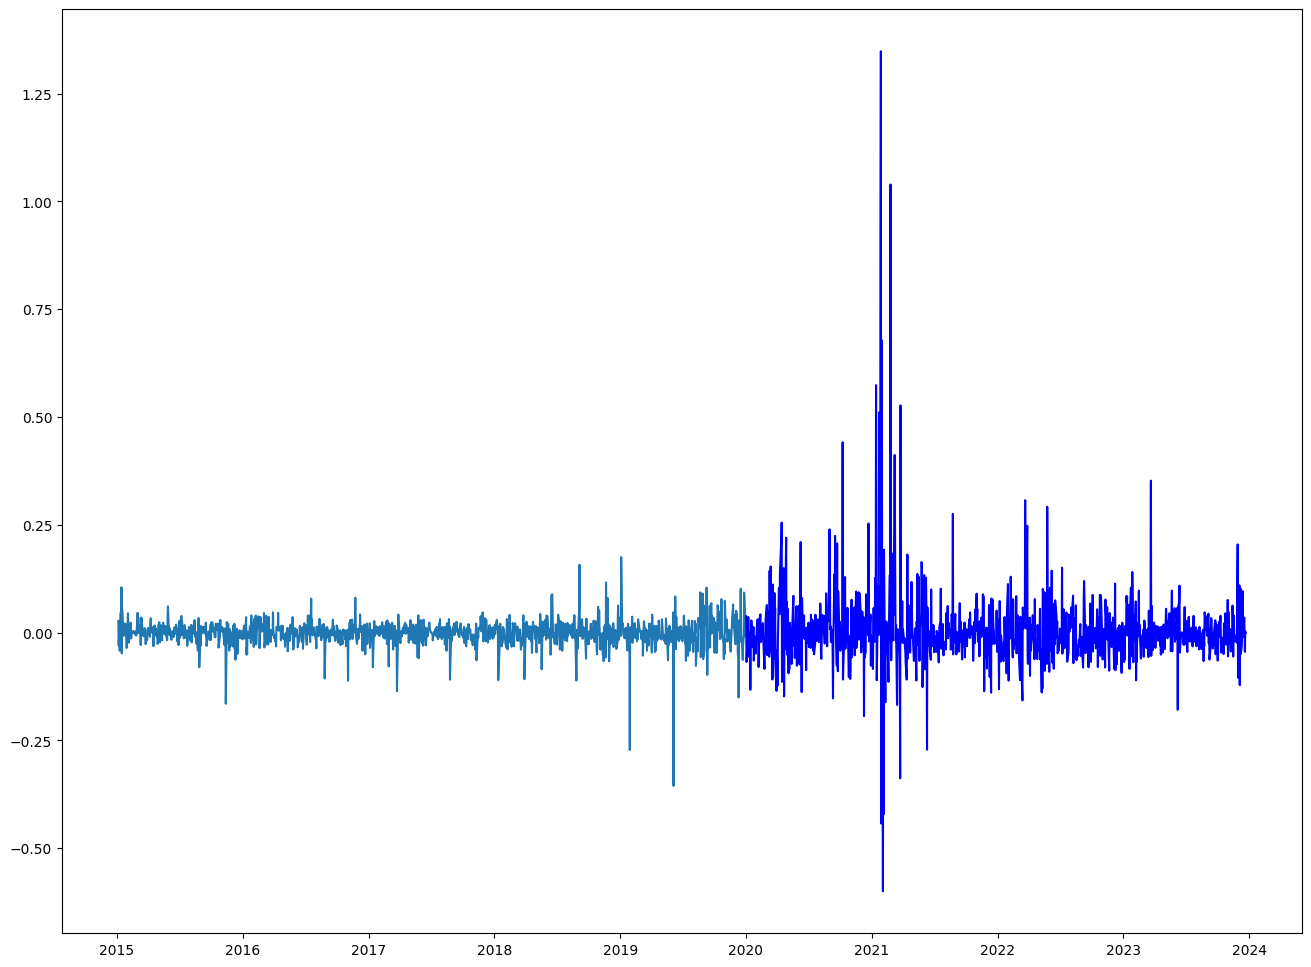

In [ ]:
plt.figure(figsize=(16, 12))
plt.plot(in_sample['date'], in_sample.select('returns').to_pandas()['returns'], label='In-sample Data')
plt.plot(out_of_sample['date'], out_of_sample.select('returns').to_pandas()['returns'], label='Out-of-sample Data', color='blue')
plt.plot(out_of_sample['date'], out_of_sample_forecasts, label='Out-of-sample Forecast', color='red')
plt.fill_between(out_of_sample['date'], out_of_sample_forecasts - 1.96 * np.sqrt(out_of_sample_variances),
                 out_of_sample_forecasts + 1.96 * np.sqrt(out_of_sample_variances), color='pink', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.show()
